<a href="https://colab.research.google.com/github/Eshapriyadarshi/Automated-ECG-Detection-Using-DNN/blob/main/Copy_of_CNN%2Blstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax, Nadam, SGD

from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
from tensorflow.keras.layers import Bidirectional
from keras.layers import Dense, LSTM, Dropout
from keras.layers import MaxPooling1D, GlobalAveragePooling1D, MaxPool1D
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

In [ ]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle/

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d taejoongyoon/mitbit-arrhythmia-database

 97% 281M/288M [00:06<00:00, 58.3MB/s]
100% 288M/288M [00:06<00:00, 50.0MB/s]


In [ ]:
! unzip /content/mitbit-arrhythmia-database.zip 

Archive:  /content/mitbit-arrhythmia-database.zip
  inflating: mitbih_database/100.csv  
  inflating: mitbih_database/100annotations.txt  
  inflating: mitbih_database/101.csv  
  inflating: mitbih_database/101annotations.txt  
  inflating: mitbih_database/102.csv  
  inflating: mitbih_database/102annotations.txt  
  inflating: mitbih_database/103.csv  
  inflating: mitbih_database/103annotations.txt  
  inflating: mitbih_database/104.csv  
  inflating: mitbih_database/104annotations.txt  
  inflating: mitbih_database/105.csv  
  inflating: mitbih_database/105annotations.txt  
  inflating: mitbih_database/106.csv  
  inflating: mitbih_database/106annotations.txt  
  inflating: mitbih_database/107.csv  
  inflating: mitbih_database/107annotations.txt  
  inflating: mitbih_database/108.csv  
  inflating: mitbih_database/108annotations.txt  
  inflating: mitbih_database/109.csv  
  inflating: mitbih_database/109annotations.txt  
  inflating: mitbih_database/111.csv  
  inflating: mitbih_d

## DATA PREPARATION

In [ ]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

In [ ]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [ ]:
path = '/content/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [ ]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [ ]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
  
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

## Data Extraction and Preprocessing

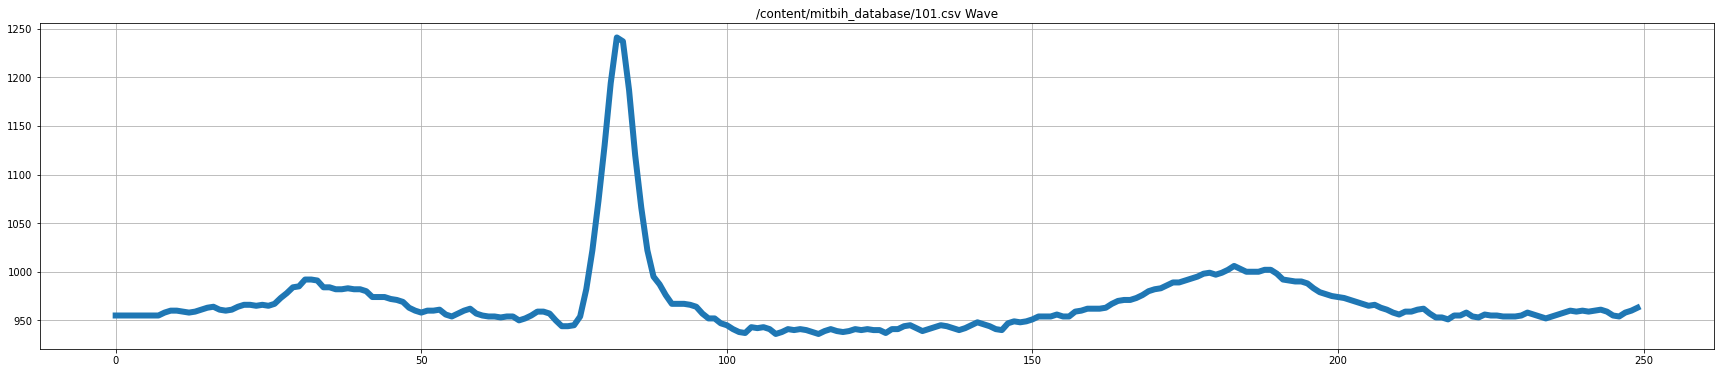

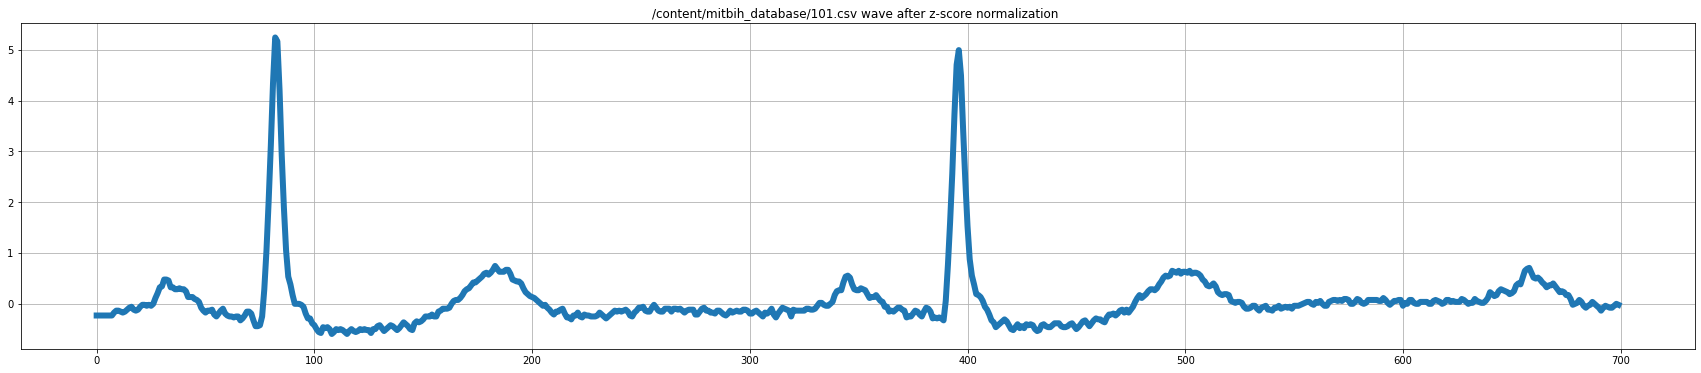

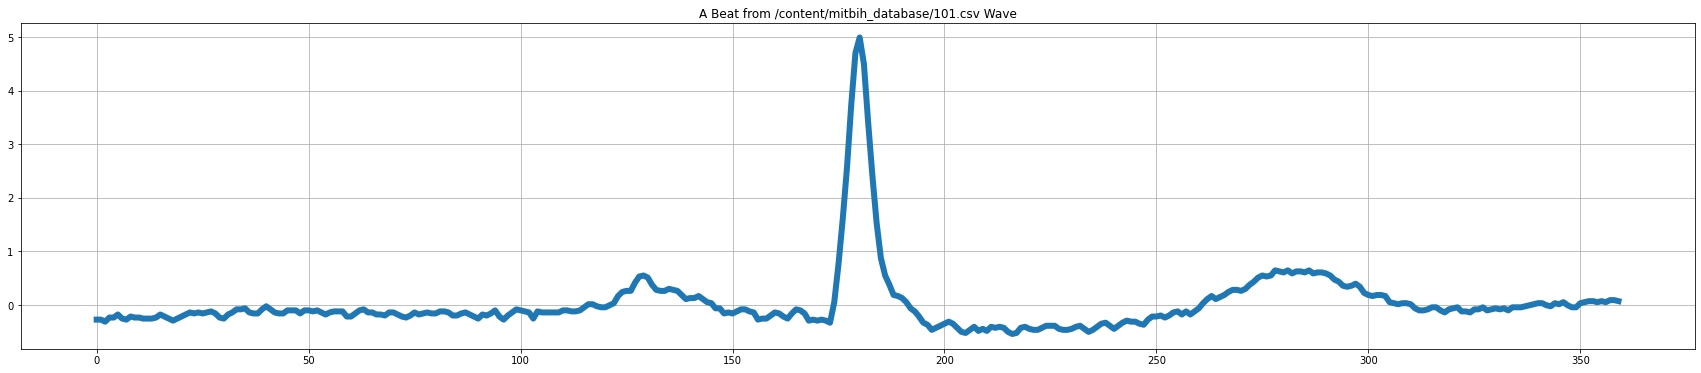

(100012, 360) (100012,)


In [ ]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:250])
        plt.show()
    #signals = denoise(signals)
    # Plot an example to the signals
    
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [ ]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


## Classes Distribution

0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


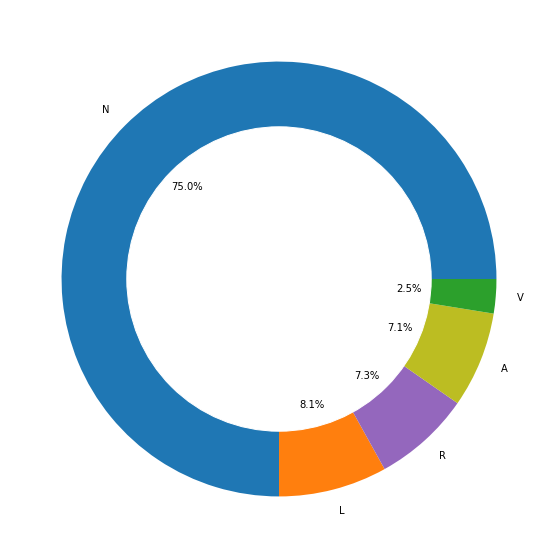

In [ ]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Rebalancing Classes

In [ ]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


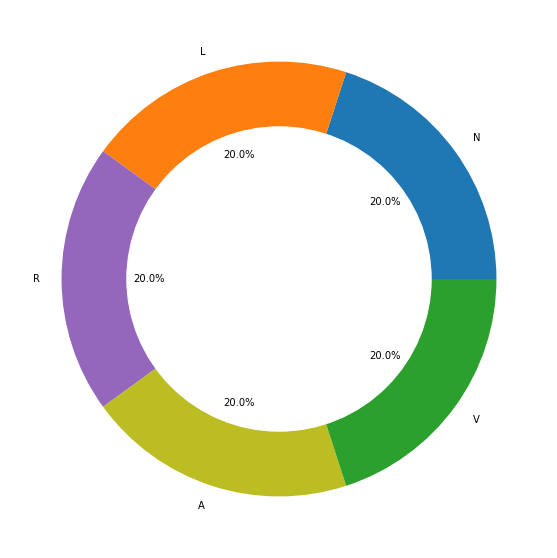

In [ ]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Train-Test Split

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


## Building the Model Architecture

## CNN + LSTM

## lr=0.001

In [ ]:
model1 = Sequential()
model1.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
model1.add(Conv1D(128, 3, activation='relu',padding = "same"))

model1.add(MaxPooling1D(10))
model1.add(Dropout(0.3))

model1.add(Conv1D(128, 5, activation='relu',padding = "same"))
model1.add(Conv1D(128, 3, activation='relu',padding = "same"))

model1.add(MaxPooling1D(5))
model1.add(Dropout(0.3))

model1.add(Bidirectional(LSTM(64, return_sequences=True)))

model1.add(Conv1D(128, 5, activation='relu',padding = "same"))
model1.add(Conv1D(128, 3, activation='relu',padding = "same"))

model1.add(GlobalAveragePooling1D())
model1.add(BatchNormalization())


# model.add(Flatten())
model1.add(Dense(256, kernel_initializer='normal', activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(128, kernel_initializer='normal', activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(64, kernel_initializer='normal', activation='relu'))
model1.add(Dropout(0.3))

model1.add(Dense(5, kernel_initializer='normal', activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 128)          768       
                                                                 
 conv1d_1 (Conv1D)           (None, 360, 128)          49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 36, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 36, 128)           82048     
                                                                 
 conv1d_3 (Conv1D)           (None, 36, 128)           49280     
                                                        

In [ ]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)
model1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model1.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 88s 149ms/step - loss: 0.6562 - accuracy: 0.7512 - val_loss: 0.2108 - val_accuracy: 0.9284
Epoch 2/100
556/556 [==============================] - 83s 150ms/step - loss: 0.2434 - accuracy: 0.9247 - val_loss: 0.2711 - val_accuracy: 0.9108
Epoch 3/100
556/556 [==============================] - 91s 163ms/step - loss: 0.1746 - accuracy: 0.9444 - val_loss: 0.1117 - val_accuracy: 0.9656
Epoch 4/100
556/556 [==============================] - 82s 148ms/step - loss: 0.1504 - accuracy: 0.9548 - val_loss: 0.0830 - val_accuracy: 0.9718
Epoch 5/100
556/556 [==============================] - 83s 149ms/step - loss: 0.1196 - accuracy: 0.9607 - val_loss: 0.0829 - val_accuracy: 0.9778
Epoch 6/100
556/556 [==============================] - 82s 148ms/step - loss: 0.1167 - accuracy: 0.9633 - val_loss: 0.0911 - val_accuracy: 0.9722
Epoch 7/100
556/556 [==============================] - 83s 149ms/step - loss: 0.1009 - accuracy: 0.9692 - val_loss: 0.0836 -

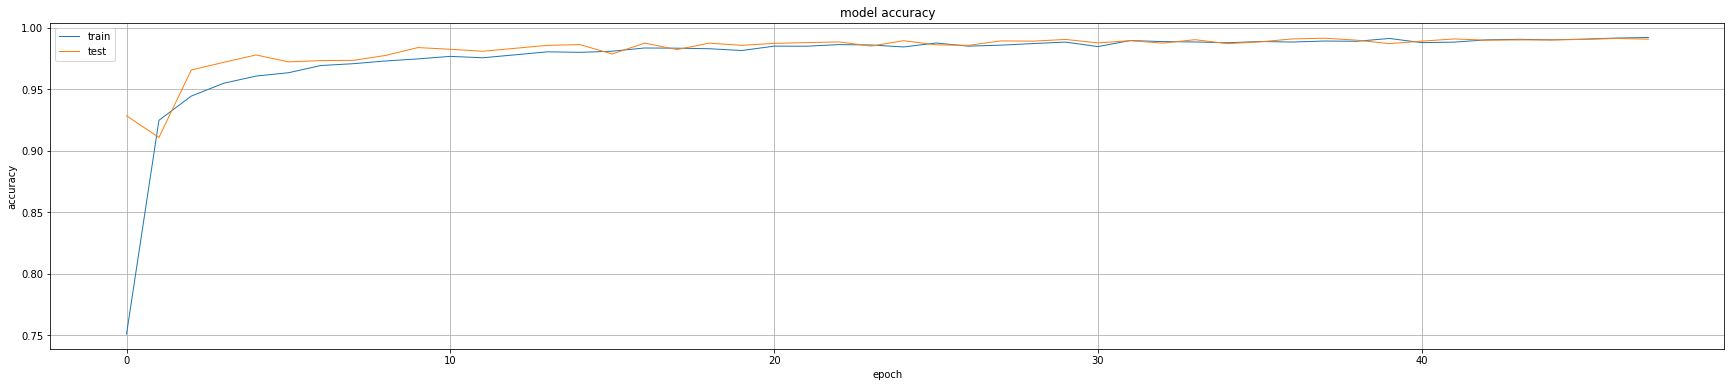

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

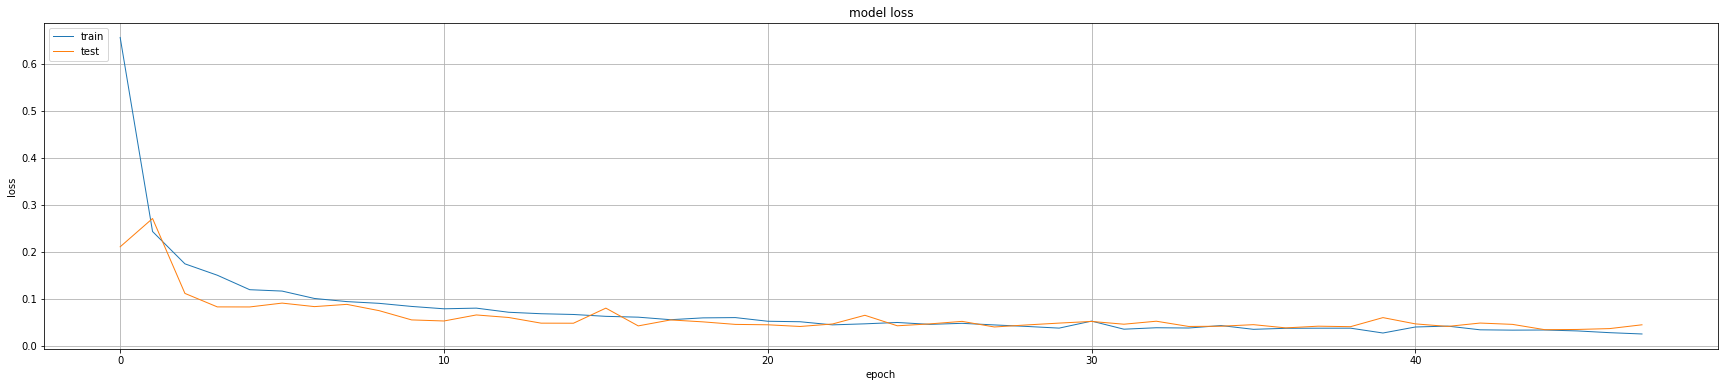

In [ ]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model1.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 6s 36ms/step - loss: 0.0420 - accuracy: 0.9914
Test Loss: 0.041966184973716736
Test accuracy: 0.9914000034332275


In [ ]:
predictions = model1.predict(test_x)
print(predictions)

[[9.6742725e-01 6.3730648e-04 4.1551902e-03 1.5900478e-02 1.1879817e-02]
 [6.7812973e-09 2.6352591e-17 9.9999988e-01 6.8172760e-08 1.8520099e-12]
 [1.0477193e-11 7.0015079e-14 1.0027154e-16 8.9524659e-11 1.0000000e+00]
 ...
 [1.1967778e-10 1.0000000e+00 2.2494678e-19 4.8729762e-17 1.0995659e-11]
 [2.1870365e-14 1.9684899e-27 2.5169262e-15 1.0000000e+00 2.2119800e-15]
 [7.1277247e-17 5.2545115e-32 4.1370748e-18 1.0000000e+00 9.5637026e-18]]


In [ ]:
y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[ 994    0    0   13    3]
 [   2  962    0    0    4]
 [   1    0 1021    0    0]
 [   9    0    0  964    1]
 [   6    1    0    3 1016]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

Accuracy:  0.99656
Precision:  0.9913936132014459
Recall:  0.9914071973047527
TNR:  0.9978495479129835
FNR:  0.00859280269524726
FPR:  0.0021504520870164086
NPV:  0.9978506905940115


In [ ]:
f1 = 2*((Precision*Recall)/(Precision+Recall))
f1

0.9914004052065671

# lr=0.005

In [ ]:
model3 = Sequential()
model3.add(Conv1D(128, 5, activation='relu', padding = "same",input_shape=(360, 1)))
model3.add(Conv1D(128, 3, activation='relu',padding = "same"))

model3.add(MaxPooling1D(10))
model3.add(Dropout(0.3))

model3.add(Conv1D(128, 5, activation='relu',padding = "same"))
model3.add(Conv1D(128, 3, activation='relu',padding = "same"))

model3.add(MaxPooling1D(5))
model3.add(Dropout(0.3))

model3.add(Bidirectional(LSTM(64, return_sequences=True)))

model3.add(Conv1D(128, 5, activation='relu',padding = "same"))
model3.add(Conv1D(128, 3, activation='relu',padding = "same"))

model3.add(GlobalAveragePooling1D())
model3.add(BatchNormalization())

# model.add(Flatten())
model3.add(Dense(256, kernel_initializer='normal', activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(128, kernel_initializer='normal', activation='relu'))
model3.add(Dropout(0.3))

model3.add(Dense(64, kernel_initializer='normal', activation='relu'))
model3.add(Dropout(0.3))

model3.add(Dense(5, kernel_initializer='normal', activation='softmax'))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 360, 128)          768       
                                                                 
 conv1d_25 (Conv1D)          (None, 360, 128)          49280     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 36, 128)          0         
 1D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 36, 128)           0         
                                                                 
 conv1d_26 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_27 (Conv1D)          (None, 36, 128)           49280     
                                                      

In [ ]:
adam = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)
model3.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model3.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 91s 156ms/step - loss: 0.9258 - accuracy: 0.6087 - val_loss: 0.7821 - val_accuracy: 0.6908
Epoch 2/100
556/556 [==============================] - 85s 153ms/step - loss: 0.6590 - accuracy: 0.7342 - val_loss: 0.4447 - val_accuracy: 0.8556
Epoch 3/100
556/556 [==============================] - 85s 153ms/step - loss: 0.5406 - accuracy: 0.8145 - val_loss: 0.4111 - val_accuracy: 0.8538
Epoch 4/100
556/556 [==============================] - 85s 152ms/step - loss: 0.4847 - accuracy: 0.8375 - val_loss: 0.3326 - val_accuracy: 0.8732
Epoch 5/100
556/556 [==============================] - 84s 151ms/step - loss: 0.3948 - accuracy: 0.8711 - val_loss: 0.3302 - val_accuracy: 0.8972
Epoch 6/100
556/556 [==============================] - 85s 153ms/step - loss: 0.4183 - accuracy: 0.8636 - val_loss: 0.3029 - val_accuracy: 0.8924
Epoch 7/100
556/556 [==============================] - 84s 152ms/step - loss: 0.3804 - accuracy: 0.8779 - val_loss: 0.2567 -

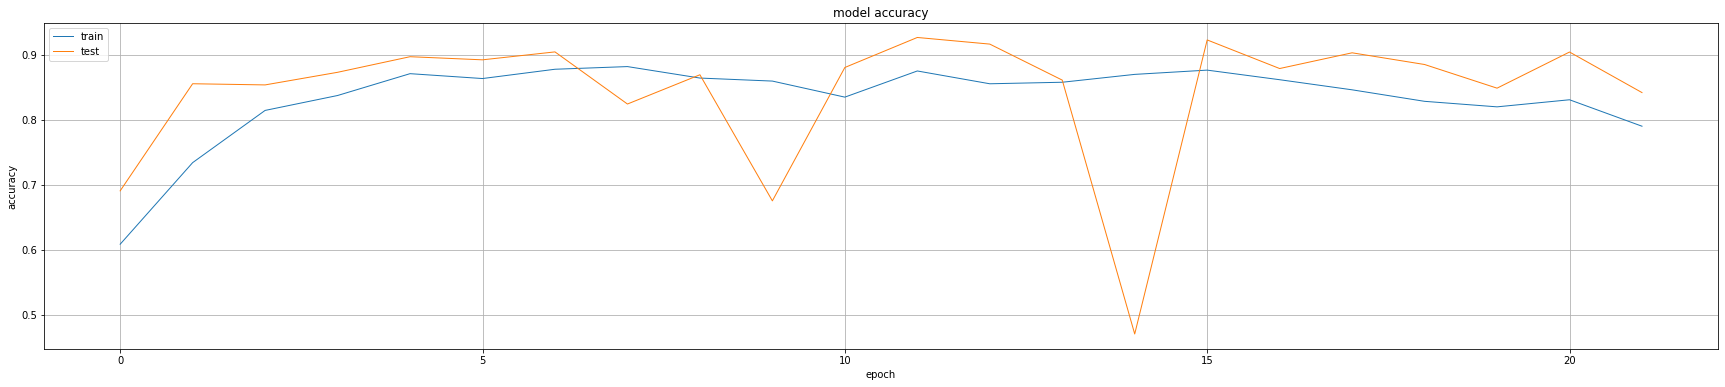

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

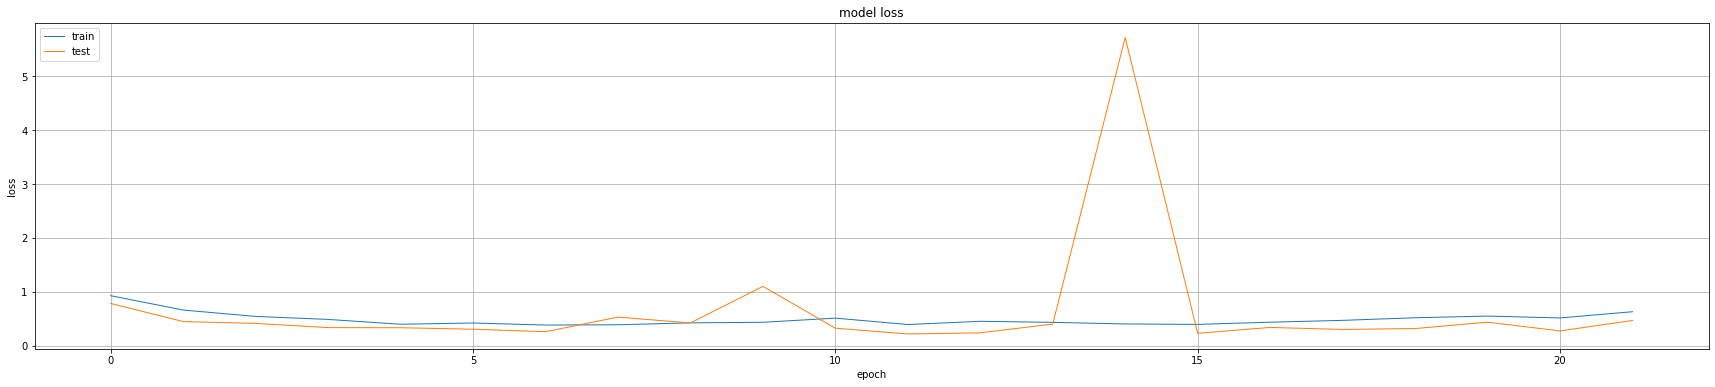

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model4 = Sequential()
model4.add(Conv1D(128, 5, activation='relu', padding = "same",input_shape=(360, 1)))
model4.add(Conv1D(128, 3, activation='relu',padding = "same"))

model4.add(MaxPooling1D(10))
model4.add(Dropout(0.3))

model4.add(Conv1D(128, 5, activation='relu',padding = "same"))
model4.add(Conv1D(128, 3, activation='relu',padding = "same"))

model4.add(MaxPooling1D(5))
model4.add(Dropout(0.3))

model4.add(Bidirectional(LSTM(64, return_sequences=True)))

model4.add(Conv1D(128, 5, activation='relu',padding = "same"))
model4.add(Conv1D(128, 3, activation='relu',padding = "same"))

model4.add(GlobalAveragePooling1D())
model4.add(BatchNormalization())

# model.add(Flatten())
model4.add(Dense(256, kernel_initializer='normal', activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(128, kernel_initializer='normal', activation='relu'))
model4.add(Dropout(0.3))

model4.add(Dense(64, kernel_initializer='normal', activation='relu'))
model4.add(Dropout(0.3))

model4.add(Dense(5, kernel_initializer='normal', activation='softmax'))
model4.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 360, 128)          768       
                                                                 
 conv1d_17 (Conv1D)          (None, 360, 128)          49280     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 36, 128)          0         
 1D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 36, 128)           0         
                                                                 
 conv1d_18 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_19 (Conv1D)          (None, 36, 128)           49280     
                                                      

In [ ]:
adam = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
model4.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model4.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 22s 12ms/step - loss: 1.2885 - accuracy: 0.4489 - val_loss: 2.0465 - val_accuracy: 0.2244
Epoch 2/100
556/556 [==============================] - 6s 11ms/step - loss: 1.4186 - accuracy: 0.3803 - val_loss: 1.5425 - val_accuracy: 0.3048
Epoch 3/100
556/556 [==============================] - 6s 10ms/step - loss: 1.4564 - accuracy: 0.3701 - val_loss: 1.5229 - val_accuracy: 0.3112
Epoch 4/100
556/556 [==============================] - 6s 11ms/step - loss: 1.4226 - accuracy: 0.3965 - val_loss: 1.6394 - val_accuracy: 0.2630
Epoch 5/100
556/556 [==============================] - 6s 11ms/step - loss: 1.5409 - accuracy: 0.2885 - val_loss: 1.6073 - val_accuracy: 0.2340
Epoch 6/100
556/556 [==============================] - 6s 11ms/step - loss: 1.6028 - accuracy: 0.2207 - val_loss: 1.5718 - val_accuracy: 0.2400
Epoch 7/100
556/556 [==============================] - 6s 11ms/step - loss: 1.6018 - accuracy: 0.2201 - val_loss: 2.2084 - val_accuracy

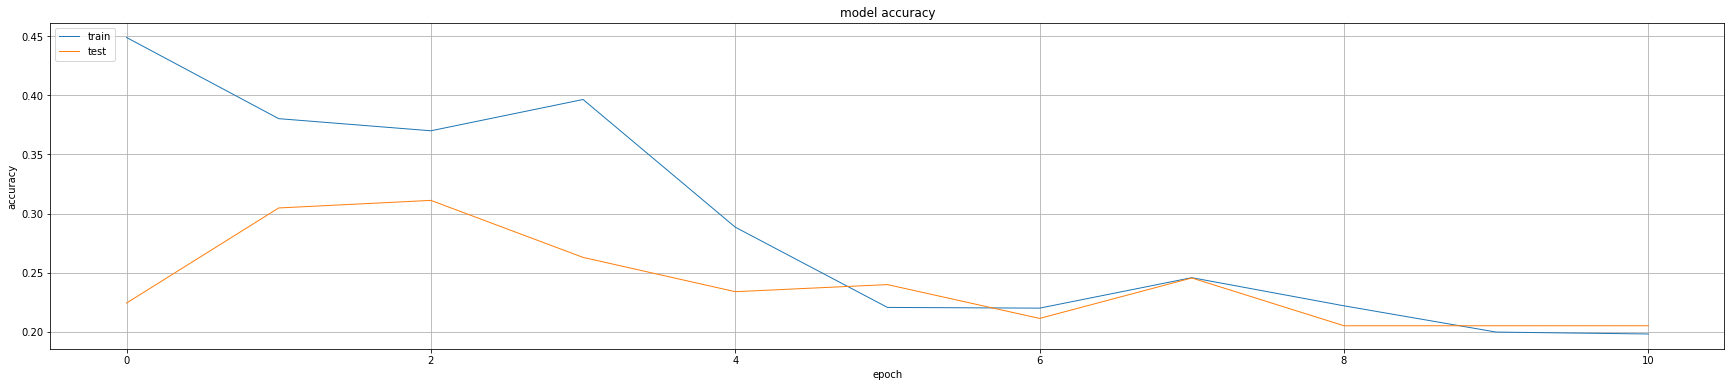

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

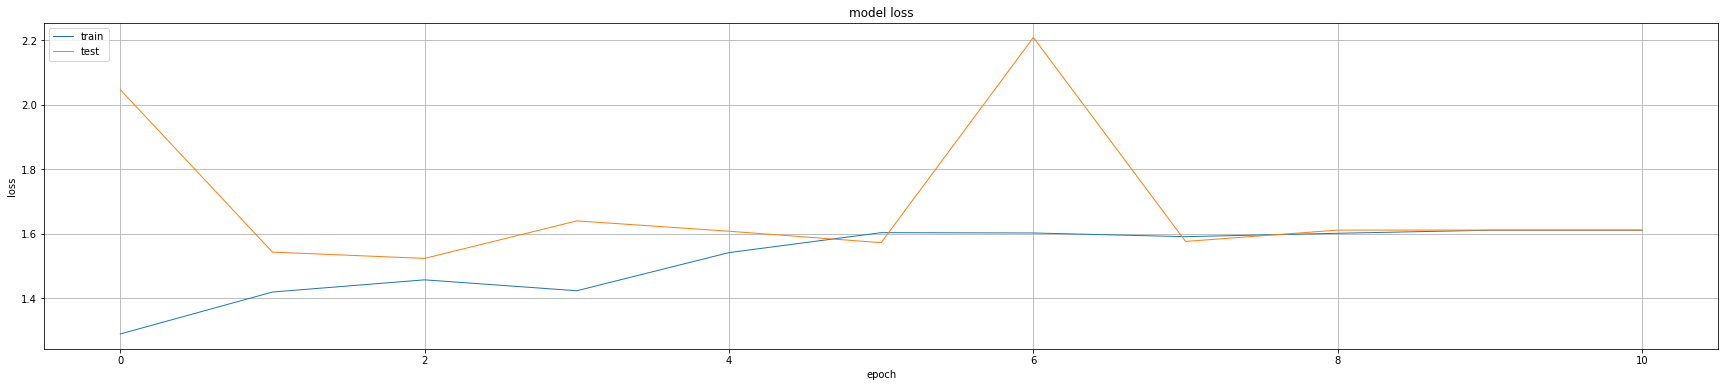

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# DROPOUT VARIATION

# dropout=0.1 lr=0.001

In [ ]:
model11 = Sequential()
model11.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
model11.add(Conv1D(128, 3, activation='relu',padding = "same"))

model11.add(MaxPooling1D(10))
model11.add(Dropout(0.1))

model11.add(Conv1D(128, 5, activation='relu',padding = "same"))
model11.add(Conv1D(128, 3, activation='relu',padding = "same"))

model11.add(MaxPooling1D(5))
model11.add(Dropout(0.1))

model11.add(Bidirectional(LSTM(64, return_sequences=True)))

model11.add(Conv1D(128, 5, activation='relu',padding = "same"))
model11.add(Conv1D(128, 3, activation='relu',padding = "same"))

model11.add(GlobalAveragePooling1D())
model11.add(BatchNormalization())

# model.add(Flatten())
model11.add(Dense(256, kernel_initializer='normal', activation='relu'))
model11.add(Dropout(0.1))
model11.add(Dense(128, kernel_initializer='normal', activation='relu'))
model11.add(Dropout(0.1))
model11.add(Dense(64, kernel_initializer='normal', activation='relu'))
model11.add(Dropout(0.1))

model11.add(Dense(5, kernel_initializer='normal', activation='softmax'))
model11.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 360, 128)          768       
                                                                 
 conv1d_55 (Conv1D)          (None, 360, 128)          49280     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 36, 128)          0         
 g1D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 36, 128)           0         
                                                                 
 conv1d_56 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_57 (Conv1D)          (None, 36, 128)           49280     
                                                      

In [ ]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
model11.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model11.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 14s 19ms/step - loss: 0.4749 - accuracy: 0.8293 - val_loss: 0.8300 - val_accuracy: 0.7340
Epoch 2/100
556/556 [==============================] - 7s 13ms/step - loss: 0.1992 - accuracy: 0.9355 - val_loss: 0.2301 - val_accuracy: 0.9252
Epoch 3/100
556/556 [==============================] - 8s 15ms/step - loss: 0.1466 - accuracy: 0.9518 - val_loss: 0.1460 - val_accuracy: 0.9488
Epoch 4/100
556/556 [==============================] - 6s 12ms/step - loss: 0.1154 - accuracy: 0.9627 - val_loss: 0.1587 - val_accuracy: 0.9554
Epoch 5/100
556/556 [==============================] - 7s 12ms/step - loss: 0.1017 - accuracy: 0.9669 - val_loss: 0.0973 - val_accuracy: 0.9670
Epoch 6/100
556/556 [==============================] - 7s 12ms/step - loss: 0.0838 - accuracy: 0.9737 - val_loss: 0.0714 - val_accuracy: 0.9770
Epoch 7/100
556/556 [==============================] - 6s 12ms/step - loss: 0.0736 - accuracy: 0.9771 - val_loss: 0.0943 - val_accuracy

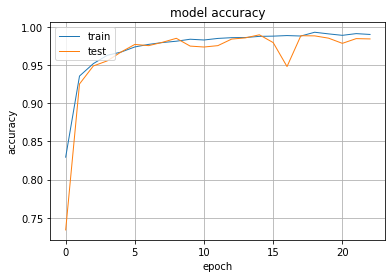

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

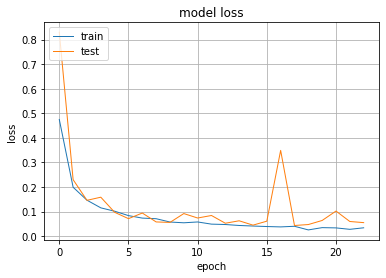

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model11.predict(test_x)
#print(predictions)

y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1031    1    0    9   10]
 [   2  956    0    0    2]
 [   0    0  994    3    0]
 [  13    0    0 1020    0]
 [  11    0    0    2  946]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

f1 = 2*((Precision*Recall)/(Precision+Recall))
print('F1 score ', f1)

Accuracy:  0.99576
Precision:  0.9895308637023691
Recall:  0.9896582802824009
TNR:  0.9973390775153854
FNR:  0.010341719717599136
FPR:  0.002660922484614575
NPV:  0.9973339705509814
F1 score  0.9895945678909617


# dropout=0.2

In [ ]:
model12 = Sequential()
model12.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
model12.add(Conv1D(128, 3, activation='relu',padding = "same"))

model12.add(MaxPooling1D(10))
model12.add(Dropout(0.2))

model12.add(Conv1D(128, 5, activation='relu',padding = "same"))
model12.add(Conv1D(128, 3, activation='relu',padding = "same"))

model12.add(MaxPooling1D(5))
model12.add(Dropout(0.2))

model12.add(Bidirectional(LSTM(64, return_sequences=True)))

model12.add(Conv1D(128, 5, activation='relu',padding = "same"))
model12.add(Conv1D(128, 3, activation='relu',padding = "same"))

model12.add(GlobalAveragePooling1D())
model12.add(BatchNormalization())

# model.add(Flatten())
model12.add(Dense(256, kernel_initializer='normal', activation='relu'))
model12.add(Dropout(0.2))
model12.add(Dense(128, kernel_initializer='normal', activation='relu'))
model12.add(Dropout(0.2))
model12.add(Dense(64, kernel_initializer='normal', activation='relu'))
model12.add(Dropout(0.2))

model12.add(Dense(5, kernel_initializer='normal', activation='softmax'))
model12.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 128)          768       
                                                                 
 conv1d_1 (Conv1D)           (None, 360, 128)          49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 36, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 36, 128)           82048     
                                                                 
 conv1d_3 (Conv1D)           (None, 36, 128)           49280     
                                                        

In [ ]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
model12.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model12.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 42s 44ms/step - loss: 0.5305 - accuracy: 0.8099 - val_loss: 0.1905 - val_accuracy: 0.9322
Epoch 2/100
556/556 [==============================] - 15s 28ms/step - loss: 0.2099 - accuracy: 0.9315 - val_loss: 0.2098 - val_accuracy: 0.9298
Epoch 3/100
556/556 [==============================] - 13s 24ms/step - loss: 0.1493 - accuracy: 0.9510 - val_loss: 0.1154 - val_accuracy: 0.9616
Epoch 4/100
556/556 [==============================] - 12s 21ms/step - loss: 0.1273 - accuracy: 0.9575 - val_loss: 0.0959 - val_accuracy: 0.9708
Epoch 5/100
556/556 [==============================] - 12s 21ms/step - loss: 0.1019 - accuracy: 0.9663 - val_loss: 0.1171 - val_accuracy: 0.9616
Epoch 6/100
556/556 [==============================] - 12s 21ms/step - loss: 0.0958 - accuracy: 0.9682 - val_loss: 0.0652 - val_accuracy: 0.9812
Epoch 7/100
556/556 [==============================] - 12s 21ms/step - loss: 0.0839 - accuracy: 0.9730 - val_loss: 0.0650 - val_ac

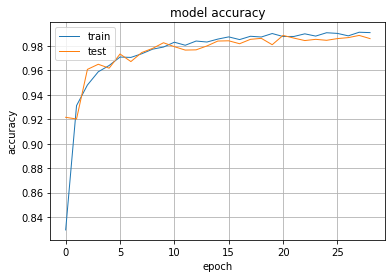

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

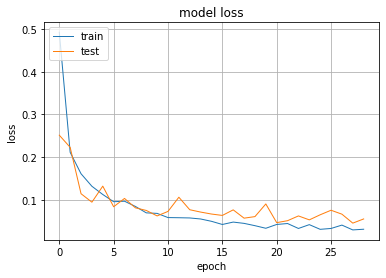

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model12.predict(test_x)
#print(predictions)

y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[ 953    3    0   10    6]
 [   3 1034    1    0    0]
 [   2    0  999    3    1]
 [  16    0    3  949    0]
 [   7    1    0    5 1004]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

f1 = 2*((Precision*Recall)/(Precision+Recall))
print('F1 score ', f1)

Accuracy:  0.99512
Precision:  0.9876436335448009
Recall:  0.9876155974126766
TNR:  0.9969583287154803
FNR:  0.012384402587323496
FPR:  0.00304167128451961
NPV:  0.9969632123491365
F1 score  0.9876296152797712


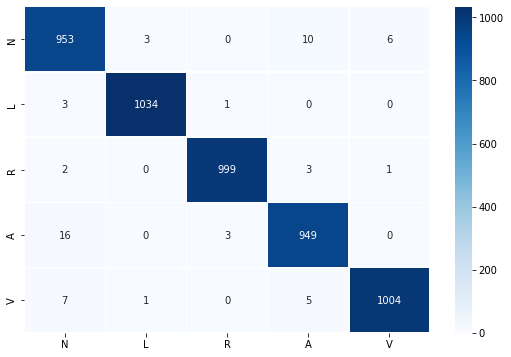

In [ ]:
import seaborn as sn
labels = ['N', 'L', 'R', 'A', 'V']
df_cm = pd.DataFrame(matrix, index = labels,
                  columns = labels)
fig = plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
sn.heatmap(df_cm,annot = True,cmap = "Blues",fmt="d",linewidths=.5)

# Dropout=0.3

In [ ]:
model13 = Sequential()
model13.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
model13.add(Conv1D(128, 3, activation='relu',padding = "same"))

model13.add(MaxPooling1D(10))
model13.add(Dropout(0.3))

model13.add(Conv1D(128, 5, activation='relu',padding = "same"))
model13.add(Conv1D(128, 3, activation='relu',padding = "same"))

model13.add(MaxPooling1D(5))
model13.add(Dropout(0.3))

model13.add(Bidirectional(LSTM(64, return_sequences=True)))

model13.add(Conv1D(128, 5, activation='relu',padding = "same"))
model13.add(Conv1D(128, 3, activation='relu',padding = "same"))

model13.add(GlobalAveragePooling1D())
model13.add(BatchNormalization())

# model.add(Flatten())
model13.add(Dense(256, kernel_initializer='normal', activation='relu'))
model13.add(Dropout(0.3))
model13.add(Dense(128, kernel_initializer='normal', activation='relu'))
model13.add(Dropout(0.3))
model13.add(Dense(64, kernel_initializer='normal', activation='relu'))
model13.add(Dropout(0.3))

model13.add(Dense(5, kernel_initializer='normal', activation='softmax'))
model13.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 360, 128)          768       
                                                                 
 conv1d_61 (Conv1D)          (None, 360, 128)          49280     
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 36, 128)          0         
 g1D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 36, 128)           0         
                                                                 
 conv1d_62 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_63 (Conv1D)          (None, 36, 128)           49280     
                                                     

In [ ]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
model13.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model13.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 13s 18ms/step - loss: 0.5714 - accuracy: 0.7947 - val_loss: 0.2304 - val_accuracy: 0.9258
Epoch 2/100
556/556 [==============================] - 8s 15ms/step - loss: 0.2385 - accuracy: 0.9257 - val_loss: 0.1671 - val_accuracy: 0.9474
Epoch 3/100
556/556 [==============================] - 7s 12ms/step - loss: 0.1823 - accuracy: 0.9427 - val_loss: 0.2354 - val_accuracy: 0.9428
Epoch 4/100
556/556 [==============================] - 10s 19ms/step - loss: 0.1442 - accuracy: 0.9536 - val_loss: 0.0895 - val_accuracy: 0.9692
Epoch 5/100
556/556 [==============================] - 8s 14ms/step - loss: 0.1262 - accuracy: 0.9607 - val_loss: 0.0820 - val_accuracy: 0.9716
Epoch 6/100
556/556 [==============================] - 6s 12ms/step - loss: 0.1204 - accuracy: 0.9620 - val_loss: 0.0707 - val_accuracy: 0.9764
Epoch 7/100
556/556 [==============================] - 6s 11ms/step - loss: 0.1010 - accuracy: 0.9689 - val_loss: 0.0775 - val_accurac

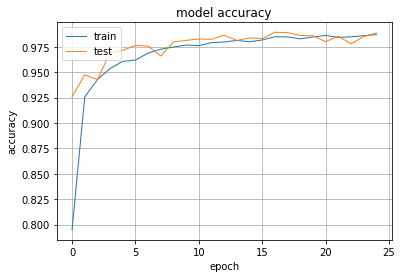

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

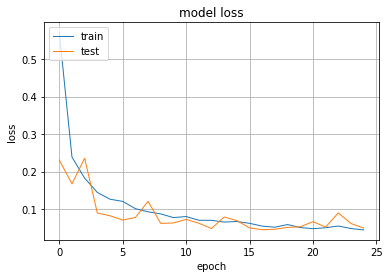

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model13.predict(test_x)
#print(predictions)

y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1028    0    0   12   11]
 [   1  957    0    0    2]
 [   0    0  997    0    0]
 [  18    0    0 1013    2]
 [   4    0    2    0  953]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

f1 = 2*((Precision*Recall)/(Precision+Recall))
print('F1 score ', f1)

Accuracy:  0.99584
Precision:  0.9898746956995487
Recall:  0.9897821786160229
TNR:  0.9973828351329619
FNR:  0.010217821383977152
FPR:  0.0026171648670382064
NPV:  0.9973878414079478
F1 score  0.9898284349959438


# Dropout=0.4

In [ ]:
model14 = Sequential()
model14.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
model14.add(Conv1D(128, 3, activation='relu',padding = "same"))

model14.add(MaxPooling1D(10))
model14.add(Dropout(0.4))

model14.add(Conv1D(128, 5, activation='relu',padding = "same"))
model14.add(Conv1D(128, 3, activation='relu',padding = "same"))

model14.add(MaxPooling1D(5))
model14.add(Dropout(0.4))

model14.add(Bidirectional(LSTM(64, return_sequences=True)))

model14.add(Conv1D(128, 5, activation='relu',padding = "same"))
model14.add(Conv1D(128, 3, activation='relu',padding = "same"))

model14.add(GlobalAveragePooling1D())
model14.add(BatchNormalization())

# model.add(Flatten())
model14.add(Dense(256, kernel_initializer='normal', activation='relu'))
model14.add(Dropout(0.4))
model14.add(Dense(128, kernel_initializer='normal', activation='relu'))
model14.add(Dropout(0.4))
model14.add(Dense(64, kernel_initializer='normal', activation='relu'))
model14.add(Dropout(0.4))
model14.add(Dense(5, kernel_initializer='normal', activation='softmax'))
model14.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_66 (Conv1D)          (None, 360, 128)          768       
                                                                 
 conv1d_67 (Conv1D)          (None, 360, 128)          49280     
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 36, 128)          0         
 g1D)                                                            
                                                                 
 dropout_55 (Dropout)        (None, 36, 128)           0         
                                                                 
 conv1d_68 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_69 (Conv1D)          (None, 36, 128)           49280     
                                                     

In [ ]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
model14.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model14.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 11s 13ms/step - loss: 0.7701 - accuracy: 0.7061 - val_loss: 0.7350 - val_accuracy: 0.8074
Epoch 2/100
556/556 [==============================] - 6s 12ms/step - loss: 0.3056 - accuracy: 0.9069 - val_loss: 0.2283 - val_accuracy: 0.9278
Epoch 3/100
556/556 [==============================] - 6s 12ms/step - loss: 0.2297 - accuracy: 0.9303 - val_loss: 0.1436 - val_accuracy: 0.9542
Epoch 4/100
556/556 [==============================] - 6s 12ms/step - loss: 0.1862 - accuracy: 0.9435 - val_loss: 0.1210 - val_accuracy: 0.9556
Epoch 5/100
556/556 [==============================] - 6s 12ms/step - loss: 0.1705 - accuracy: 0.9488 - val_loss: 0.1087 - val_accuracy: 0.9652
Epoch 6/100
556/556 [==============================] - 6s 12ms/step - loss: 0.1486 - accuracy: 0.9531 - val_loss: 0.1137 - val_accuracy: 0.9638
Epoch 7/100
556/556 [==============================] - 6s 12ms/step - loss: 0.1422 - accuracy: 0.9574 - val_loss: 0.0885 - val_accuracy

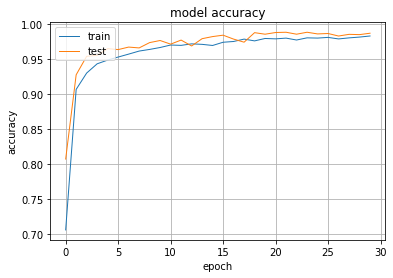

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

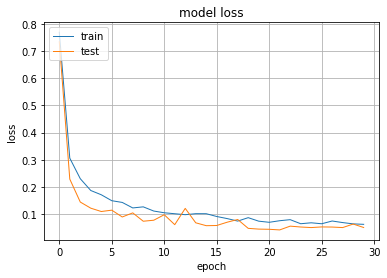

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model14.predict(test_x)
#print(predictions)

y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1051    0    0    0    0]
 [ 960    0    0    0    0]
 [ 997    0    0    0    0]
 [1033    0    0    0    0]
 [ 959    0    0    0    0]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

f1 = 2*((Precision*Recall)/(Precision+Recall))
f1

Accuracy:  0.68408
Precision:  0.2
Recall:  nan
TNR:  nan
FNR:  nan
FPR:  nan
NPV:  0.8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


nan

## dropout=0.5

In [ ]:
model15 = Sequential()
model15.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
model15.add(Conv1D(128, 3, activation='relu',padding = "same"))

model15.add(MaxPooling1D(10))
model15.add(Dropout(0.5))

model15.add(Conv1D(128, 5, activation='relu',padding = "same"))
model15.add(Conv1D(128, 3, activation='relu',padding = "same"))

model15.add(MaxPooling1D(5))
model15.add(Dropout(0.5))

model15.add(Bidirectional(LSTM(64, return_sequences=True)))

model15.add(Conv1D(128, 5, activation='relu',padding = "same"))
model15.add(Conv1D(128, 3, activation='relu',padding = "same"))

model15.add(GlobalAveragePooling1D())
model15.add(BatchNormalization())

# model.add(Flatten())
model15.add(Dense(256, kernel_initializer='normal', activation='relu'))
model15.add(Dropout(0.5))
model15.add(Dense(128, kernel_initializer='normal', activation='relu'))
model15.add(Dropout(0.5))
model15.add(Dense(64, kernel_initializer='normal', activation='relu'))
model15.add(Dropout(0.5))
model15.add(Dense(5, kernel_initializer='normal', activation='softmax'))
model15.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 360, 128)          768       
                                                                 
 conv1d_7 (Conv1D)           (None, 360, 128)          49280     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 36, 128)          0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 36, 128)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 36, 128)           82048     
                                                                 
 conv1d_9 (Conv1D)           (None, 36, 128)           49280     
                                                      

In [ ]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
model15.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model15.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 13s 17ms/step - loss: 0.9941 - accuracy: 0.5888 - val_loss: 0.6179 - val_accuracy: 0.7488
Epoch 2/100
556/556 [==============================] - 7s 13ms/step - loss: 0.4666 - accuracy: 0.8590 - val_loss: 0.2752 - val_accuracy: 0.9112
Epoch 3/100
556/556 [==============================] - 6s 11ms/step - loss: 0.3127 - accuracy: 0.9075 - val_loss: 0.1918 - val_accuracy: 0.9376
Epoch 4/100
556/556 [==============================] - 11s 19ms/step - loss: 0.2546 - accuracy: 0.9259 - val_loss: 0.1641 - val_accuracy: 0.9474
Epoch 5/100
556/556 [==============================] - 8s 14ms/step - loss: 0.2141 - accuracy: 0.9360 - val_loss: 0.1118 - val_accuracy: 0.9596
Epoch 6/100
556/556 [==============================] - 6s 11ms/step - loss: 0.1889 - accuracy: 0.9459 - val_loss: 0.1277 - val_accuracy: 0.9534
Epoch 7/100
556/556 [==============================] - 6s 11ms/step - loss: 0.1750 - accuracy: 0.9477 - val_loss: 0.1095 - val_accurac

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model15.predict(test_x)

y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1032    0    2    9    8]
 [   1  958    0    0    1]
 [   0    0  997    0    0]
 [  11    0    0 1022    0]
 [   7    0    0    3  949]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

f1 = 2*((Precision*Recall)/(Precision+Recall))
f1

Accuracy:  0.99664
Precision:  0.9917525041474248
Recall:  0.9917839978359531
TNR:  0.9978892505303506
FNR:  0.0082160021640469
FPR:  0.0021107494696493987
NPV:  0.9978873805392965


0.9917682507416676

# without batch normalization, lr=0.001, dropout=0.2

In [ ]:
model22 = Sequential()
model22.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
model22.add(Conv1D(128, 3, activation='relu',padding = "same"))

model22.add(MaxPooling1D(10))
model22.add(Dropout(0.2))

model22.add(Conv1D(128, 5, activation='relu',padding = "same"))
model22.add(Conv1D(128, 3, activation='relu',padding = "same"))

model22.add(MaxPooling1D(5))
model22.add(Dropout(0.2))

model22.add(Bidirectional(LSTM(64, return_sequences=True)))

model22.add(Conv1D(128, 5, activation='relu',padding = "same"))
model22.add(Conv1D(128, 3, activation='relu',padding = "same"))

model22.add(GlobalAveragePooling1D())
#model22.add(BatchNormalization())

# model.add(Flatten())
model22.add(Dense(256, kernel_initializer='normal', activation='relu'))
model22.add(Dropout(0.2))
model22.add(Dense(128, kernel_initializer='normal', activation='relu'))
model22.add(Dropout(0.2))
model22.add(Dense(64, kernel_initializer='normal', activation='relu'))
model22.add(Dropout(0.2))

model22.add(Dense(5, kernel_initializer='normal', activation='softmax'))
model22.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 360, 128)          768       
                                                                 
 conv1d_19 (Conv1D)          (None, 360, 128)          49280     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 36, 128)          0         
 1D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 36, 128)           0         
                                                                 
 conv1d_20 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_21 (Conv1D)          (None, 36, 128)           49280     
                                                      

In [ ]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
model22.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model22.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 12s 14ms/step - loss: 0.8208 - accuracy: 0.6302 - val_loss: 0.3041 - val_accuracy: 0.9048
Epoch 2/100
556/556 [==============================] - 6s 11ms/step - loss: 0.2363 - accuracy: 0.9283 - val_loss: 0.1267 - val_accuracy: 0.9558
Epoch 3/100
556/556 [==============================] - 6s 11ms/step - loss: 0.1663 - accuracy: 0.9481 - val_loss: 0.1210 - val_accuracy: 0.9600
Epoch 4/100
556/556 [==============================] - 6s 11ms/step - loss: 0.1336 - accuracy: 0.9571 - val_loss: 0.1273 - val_accuracy: 0.9588
Epoch 5/100
556/556 [==============================] - 6s 11ms/step - loss: 0.1168 - accuracy: 0.9643 - val_loss: 0.0822 - val_accuracy: 0.9718
Epoch 6/100
556/556 [==============================] - 6s 11ms/step - loss: 0.1016 - accuracy: 0.9680 - val_loss: 0.0990 - val_accuracy: 0.9664
Epoch 7/100
556/556 [==============================] - 7s 12ms/step - loss: 0.0902 - accuracy: 0.9719 - val_loss: 0.0656 - val_accuracy

In [ ]:
predictions = model22.predict(test_x)

y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1032    1    1    7   10]
 [   3  956    0    0    1]
 [   2    0  992    3    0]
 [  15    0    0 1018    0]
 [   7    0    0    0  952]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

f1 = 2*((Precision*Recall)/(Precision+Recall))
f1

Accuracy:  0.9960000000000001
Precision:  0.9901840368053904
Recall:  0.9902604007633892
TNR:  0.9974862624089511
FNR:  0.009739599236610783
FPR:  0.0025137375910488386
NPV:  0.9974845187153445


0.9902222173121308

# RMSPprop 0.001 0.2 drop with normalization

In [ ]:
modelA = Sequential()
modelA.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
modelA.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelA.add(MaxPooling1D(10))
modelA.add(Dropout(0.2))

modelA.add(Conv1D(128, 5, activation='relu',padding = "same"))
modelA.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelA.add(MaxPooling1D(5))
modelA.add(Dropout(0.2))

modelA.add(Bidirectional(LSTM(64, return_sequences=True)))

modelA.add(Conv1D(128, 5, activation='relu',padding = "same"))
modelA.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelA.add(GlobalAveragePooling1D())
modelA.add(BatchNormalization())

# model.add(Flatten())
modelA.add(Dense(256, kernel_initializer='normal', activation='relu'))
modelA.add(Dropout(0.2))
modelA.add(Dense(128, kernel_initializer='normal', activation='relu'))
modelA.add(Dropout(0.2))
modelA.add(Dense(64, kernel_initializer='normal', activation='relu'))
modelA.add(Dropout(0.2))

modelA.add(Dense(5, kernel_initializer='normal', activation='softmax'))
modelA.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 360, 128)          768       
                                                                 
 conv1d_25 (Conv1D)          (None, 360, 128)          49280     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 36, 128)          0         
 1D)                                                             
                                                                 
 dropout_20 (Dropout)        (None, 36, 128)           0         
                                                                 
 conv1d_26 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_27 (Conv1D)          (None, 36, 128)           49280     
                                                      

In [ ]:
rms = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.001, epsilon=1e-07,centered=False)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
modelA.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=modelA.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 12s 13ms/step - loss: 0.7307 - accuracy: 0.7155 - val_loss: 0.5877 - val_accuracy: 0.7992
Epoch 2/100
556/556 [==============================] - 6s 12ms/step - loss: 0.2730 - accuracy: 0.9157 - val_loss: 0.1642 - val_accuracy: 0.9406
Epoch 3/100
556/556 [==============================] - 6s 12ms/step - loss: 0.1911 - accuracy: 0.9397 - val_loss: 0.1182 - val_accuracy: 0.9596
Epoch 4/100
556/556 [==============================] - 7s 12ms/step - loss: 0.1601 - accuracy: 0.9488 - val_loss: 0.1843 - val_accuracy: 0.9438
Epoch 5/100
556/556 [==============================] - 7s 13ms/step - loss: 0.1410 - accuracy: 0.9541 - val_loss: 0.0885 - val_accuracy: 0.9640
Epoch 6/100
556/556 [==============================] - 6s 12ms/step - loss: 0.1210 - accuracy: 0.9622 - val_loss: 0.1075 - val_accuracy: 0.9682
Epoch 7/100
556/556 [==============================] - 6s 12ms/step - loss: 0.1097 - accuracy: 0.9657 - val_loss: 0.1099 - val_accuracy

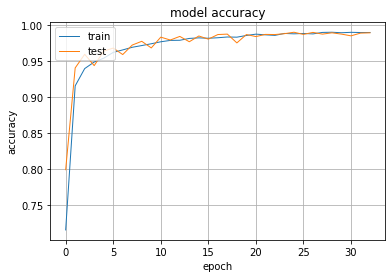

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

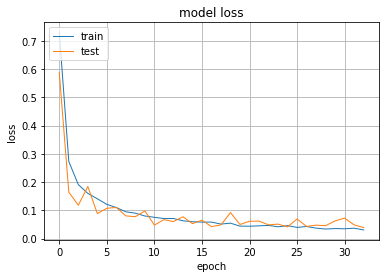

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = modelA.predict(test_x)
print(predictions)

[[8.0459202e-11 1.0000000e+00 2.4866983e-18 2.5195260e-18 1.7825554e-09]
 [1.6040456e-09 2.8156238e-12 9.9999940e-01 5.9848480e-07 1.9040186e-10]
 [8.5672568e-08 2.7079228e-19 8.3700885e-12 9.9999857e-01 1.2919805e-06]
 ...
 [3.9417597e-12 6.7818188e-15 9.9999976e-01 2.0758557e-07 5.0570442e-12]
 [1.6151985e-07 8.0316309e-18 3.3484928e-09 9.9999976e-01 1.2333946e-07]
 [7.0851285e-09 3.6457101e-11 9.9997950e-01 2.0534151e-05 4.7792654e-09]]


In [ ]:
y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1028    1    0    8   14]
 [   3  954    0    0    3]
 [   0    0  997    0    0]
 [  14    0    0 1019    0]
 [   7    0    0    1  951]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

Accuracy:  0.9959200000000001
Precision:  0.9899942596057635
Recall:  0.9899644688167841
TNR:  0.9974364306052006
FNR:  0.010035531183215976
FPR:  0.0025635693947992284
NPV:  0.9974398781752131


In [ ]:
f1 = 2*((Precision*Recall)/(Precision+Recall))
f1

0.9899793639871552

# adamax

In [ ]:
modelB = Sequential()
modelB.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
modelB.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelB.add(MaxPooling1D(10))
modelB.add(Dropout(0.2))

modelB.add(Conv1D(128, 5, activation='relu',padding = "same"))
modelB.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelB.add(MaxPooling1D(5))
modelB.add(Dropout(0.2))

modelB.add(Bidirectional(LSTM(64, return_sequences=True)))

modelB.add(Conv1D(128, 5, activation='relu',padding = "same"))
modelB.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelB.add(GlobalAveragePooling1D())
modelB.add(BatchNormalization())

# model.add(Flatten())
modelB.add(Dense(256, kernel_initializer='normal', activation='relu'))
modelB.add(Dropout(0.2))
modelB.add(Dense(128, kernel_initializer='normal', activation='relu'))
modelB.add(Dropout(0.2))
modelB.add(Dense(64, kernel_initializer='normal', activation='relu'))
modelB.add(Dropout(0.2))

modelB.add(Dense(5, kernel_initializer='normal', activation='softmax'))
modelB.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 360, 128)          768       
                                                                 
 conv1d_37 (Conv1D)          (None, 360, 128)          49280     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 36, 128)          0         
 g1D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 36, 128)           0         
                                                                 
 conv1d_38 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_39 (Conv1D)          (None, 36, 128)           49280     
                                                      

In [ ]:
adamax=Adamax(learning_rate=0.001)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
modelB.compile(loss='categorical_crossentropy', optimizer=adamax, metrics=['accuracy'])
history=modelB.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 12s 14ms/step - loss: 0.6818 - accuracy: 0.7486 - val_loss: 0.3083 - val_accuracy: 0.8930
Epoch 2/100
556/556 [==============================] - 7s 12ms/step - loss: 0.2691 - accuracy: 0.9115 - val_loss: 0.2177 - val_accuracy: 0.9266
Epoch 3/100
556/556 [==============================] - 7s 12ms/step - loss: 0.1913 - accuracy: 0.9370 - val_loss: 0.1287 - val_accuracy: 0.9526
Epoch 4/100
556/556 [==============================] - 7s 12ms/step - loss: 0.1580 - accuracy: 0.9481 - val_loss: 0.2423 - val_accuracy: 0.9264
Epoch 5/100
556/556 [==============================] - 7s 12ms/step - loss: 0.1312 - accuracy: 0.9539 - val_loss: 0.1073 - val_accuracy: 0.9640
Epoch 6/100
556/556 [==============================] - 7s 12ms/step - loss: 0.1175 - accuracy: 0.9609 - val_loss: 0.1202 - val_accuracy: 0.9590
Epoch 7/100
556/556 [==============================] - 7s 12ms/step - loss: 0.1033 - accuracy: 0.9659 - val_loss: 0.0892 - val_accuracy

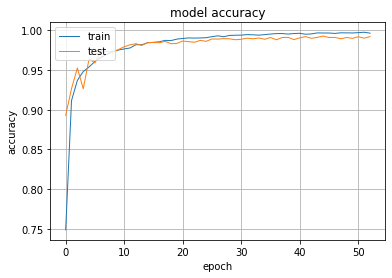

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

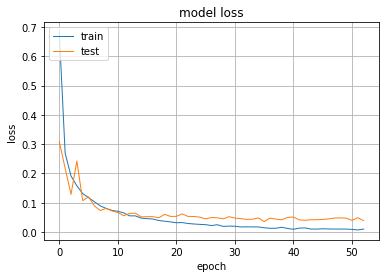

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = modelB.predict(test_x)
print(predictions)


[[1.9099687e-08 1.0000000e+00 3.6047071e-10 1.7110098e-13 3.3806513e-09]
 [1.2322109e-09 1.3920238e-12 1.0000000e+00 2.5897583e-08 3.9849851e-12]
 [2.5438572e-15 3.5760640e-20 2.2565725e-14 1.0000000e+00 4.9820252e-12]
 ...
 [5.1399807e-10 3.4476651e-12 1.0000000e+00 4.7396227e-08 5.5683661e-12]
 [1.6386515e-11 4.9605669e-16 2.9416777e-10 1.0000000e+00 1.5283384e-11]
 [1.0595496e-08 2.2264864e-11 1.0000000e+00 2.2216538e-08 1.9106508e-11]]


In [ ]:

y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)



[[1031    1    0   15    4]
 [   1  957    0    0    2]
 [   0    0  997    0    0]
 [   8    0    0 1025    0]
 [   5    0    0    0  954]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

f1 = 2*((Precision*Recall)/(Precision+Recall))
print('F1score: ', f1)

Accuracy:  0.99712
Precision:  0.9929774612510995
Recall:  0.9929771905108409
TNR:  0.9981886154752952
FNR:  0.007022809489159341
FPR:  0.0018113845247046604
NPV:  0.9981882596156716
F1score:  0.9929773258809518


# Nadam

In [ ]:
modelC = Sequential()
modelC.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
modelC.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelC.add(MaxPooling1D(10))
modelC.add(Dropout(0.2))

modelC.add(Conv1D(128, 5, activation='relu',padding = "same"))
modelC.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelC.add(MaxPooling1D(5))
modelC.add(Dropout(0.2))

modelC.add(Bidirectional(LSTM(64, return_sequences=True)))

modelC.add(Conv1D(128, 5, activation='relu',padding = "same"))
modelC.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelC.add(GlobalAveragePooling1D())
modelC.add(BatchNormalization())

# model.add(Flatten())
modelC.add(Dense(256, kernel_initializer='normal', activation='relu'))
modelC.add(Dropout(0.2))
modelC.add(Dense(128, kernel_initializer='normal', activation='relu'))
modelC.add(Dropout(0.2))
modelC.add(Dense(64, kernel_initializer='normal', activation='relu'))
modelC.add(Dropout(0.2))

modelC.add(Dense(5, kernel_initializer='normal', activation='softmax'))
modelC.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 360, 128)          768       
                                                                 
 conv1d_73 (Conv1D)          (None, 360, 128)          49280     
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 36, 128)          0         
 g1D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 36, 128)           0         
                                                                 
 conv1d_74 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_75 (Conv1D)          (None, 36, 128)           49280     
                                                     

In [ ]:
nadam=Nadam(learning_rate=0.001)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
modelC.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
history=modelC.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 20s 19ms/step - loss: 0.0822 - accuracy: 0.9748 - val_loss: 0.0866 - val_accuracy: 0.9696
Epoch 2/100
556/556 [==============================] - 9s 16ms/step - loss: 0.0746 - accuracy: 0.9772 - val_loss: 0.0710 - val_accuracy: 0.9806
Epoch 3/100
556/556 [==============================] - 9s 16ms/step - loss: 0.0676 - accuracy: 0.9799 - val_loss: 0.0711 - val_accuracy: 0.9826
Epoch 4/100
556/556 [==============================] - 12s 22ms/step - loss: 0.0583 - accuracy: 0.9826 - val_loss: 0.0768 - val_accuracy: 0.9766
Epoch 5/100
556/556 [==============================] - 16s 28ms/step - loss: 0.0693 - accuracy: 0.9799 - val_loss: 0.0665 - val_accuracy: 0.9820
Epoch 6/100
556/556 [==============================] - 13s 23ms/step - loss: 0.0596 - accuracy: 0.9823 - val_loss: 0.0502 - val_accuracy: 0.9858
Epoch 7/100
556/556 [==============================] - 14s 25ms/step - loss: 0.0528 - accuracy: 0.9847 - val_loss: 0.1113 - val_accu

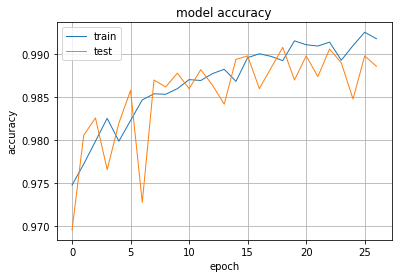

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

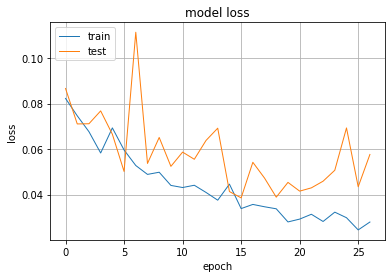

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = modelB.predict(test_x)
y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1031    1    0   15    4]
 [   1  957    0    0    2]
 [   0    0  997    0    0]
 [   8    0    0 1025    0]
 [   5    0    0    0  954]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

f1 = 2*((Precision*Recall)/(Precision+Recall))
f1

Accuracy:  0.99712
Precision:  0.9929774612510995
Recall:  0.9929771905108409
TNR:  0.9981886154752952
FNR:  0.007022809489159341
FPR:  0.0018113845247046604
NPV:  0.9981882596156716


0.9929773258809518

In [ ]:
import seaborn as sn
labels = ['N', 'L', 'R', 'A', 'V']
df_cm = pd.DataFrame(matrix, index = labels,
                  columns = labels)
fig = plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
sn.heatmap(df_cm,annot = True,cmap = "Blues",fmt="d",linewidths=.5)

# SGD

In [ ]:
modelD = Sequential()
modelD.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
modelD.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelD.add(MaxPooling1D(10))
modelD.add(Dropout(0.2))

modelD.add(Conv1D(128, 5, activation='relu',padding = "same"))
modelD.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelD.add(MaxPooling1D(5))
modelD.add(Dropout(0.2))

modelD.add(Bidirectional(LSTM(64, return_sequences=True)))

modelD.add(Conv1D(128, 5, activation='relu',padding = "same"))
modelD.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelD.add(GlobalAveragePooling1D())
modelD.add(BatchNormalization())

# model.add(Flatten())
modelD.add(Dense(256, kernel_initializer='normal', activation='relu'))
modelD.add(Dropout(0.2))
modelD.add(Dense(128, kernel_initializer='normal', activation='relu'))
modelD.add(Dropout(0.2))
modelD.add(Dense(64, kernel_initializer='normal', activation='relu'))
modelD.add(Dropout(0.2))

modelD.add(Dense(5, kernel_initializer='normal', activation='softmax'))
modelD.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_78 (Conv1D)          (None, 360, 128)          768       
                                                                 
 conv1d_79 (Conv1D)          (None, 360, 128)          49280     
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 36, 128)          0         
 g1D)                                                            
                                                                 
 dropout_65 (Dropout)        (None, 36, 128)           0         
                                                                 
 conv1d_80 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_81 (Conv1D)          (None, 36, 128)           49280     
                                                     

In [ ]:
sgd=SGD(learning_rate=0.001, momentum=0.01)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
modelD.compile(loss='categorical_crossentropy', optimizer=adamax, metrics=['accuracy'])
history=modelD.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 13s 14ms/step - loss: 0.7016 - accuracy: 0.7400 - val_loss: 0.2819 - val_accuracy: 0.9120
Epoch 2/100
556/556 [==============================] - 7s 13ms/step - loss: 0.2809 - accuracy: 0.9076 - val_loss: 0.2654 - val_accuracy: 0.9204
Epoch 3/100
556/556 [==============================] - 7s 13ms/step - loss: 0.2019 - accuracy: 0.9342 - val_loss: 0.1857 - val_accuracy: 0.9396
Epoch 4/100
556/556 [==============================] - 7s 13ms/step - loss: 0.1673 - accuracy: 0.9455 - val_loss: 0.1468 - val_accuracy: 0.9490
Epoch 5/100
556/556 [==============================] - 7s 13ms/step - loss: 0.1408 - accuracy: 0.9515 - val_loss: 0.1018 - val_accuracy: 0.9646
Epoch 6/100
556/556 [==============================] - 7s 13ms/step - loss: 0.1172 - accuracy: 0.9595 - val_loss: 0.0983 - val_accuracy: 0.9686
Epoch 7/100
556/556 [==============================] - 7s 13ms/step - loss: 0.1065 - accuracy: 0.9625 - val_loss: 0.0948 - val_accuracy

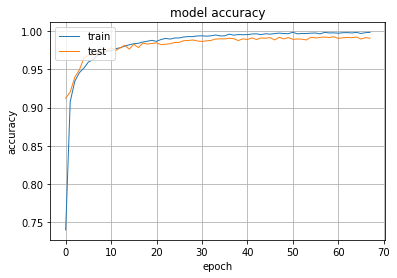

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

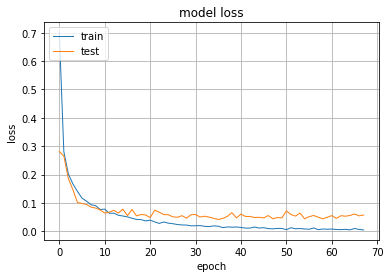

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = modelB.predict(test_x)
y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1031    1    0   15    4]
 [   1  957    0    0    2]
 [   0    0  997    0    0]
 [   8    0    0 1025    0]
 [   5    0    0    0  954]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

f1 = 2*((Precision*Recall)/(Precision+Recall))
f1

Accuracy:  0.99712
Precision:  0.9929774612510995
Recall:  0.9929771905108409
TNR:  0.9981886154752952
FNR:  0.007022809489159341
FPR:  0.0018113845247046604
NPV:  0.9981882596156716


0.9929773258809518

# loss1KL

In [ ]:
modelE = Sequential()
modelE.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
modelE.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelE.add(MaxPooling1D(10))
modelE.add(Dropout(0.2))

modelE.add(Conv1D(128, 5, activation='relu',padding = "same"))
modelE.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelE.add(MaxPooling1D(5))
modelE.add(Dropout(0.2))

modelE.add(Bidirectional(LSTM(64, return_sequences=True)))

modelE.add(Conv1D(128, 5, activation='relu',padding = "same"))
modelE.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelE.add(GlobalAveragePooling1D())
#model22.add(BatchNormalization())

# model.add(Flatten())
modelE.add(Dense(256, kernel_initializer='normal', activation='relu'))
modelE.add(Dropout(0.2))
modelE.add(Dense(128, kernel_initializer='normal', activation='relu'))
modelE.add(Dropout(0.2))
modelE.add(Dense(64, kernel_initializer='normal', activation='relu'))
modelE.add(Dropout(0.2))

modelE.add(Dense(5, kernel_initializer='normal', activation='softmax'))
modelE.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_84 (Conv1D)          (None, 360, 128)          768       
                                                                 
 conv1d_85 (Conv1D)          (None, 360, 128)          49280     
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 36, 128)          0         
 g1D)                                                            
                                                                 
 dropout_70 (Dropout)        (None, 36, 128)           0         
                                                                 
 conv1d_86 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_87 (Conv1D)          (None, 36, 128)           49280     
                                                     

In [ ]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
modelE.compile(loss='kullback_leibler_divergence', optimizer=adam, metrics=['accuracy'])
history=modelE.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 15s 17ms/step - loss: 0.7651 - accuracy: 0.6770 - val_loss: 0.2497 - val_accuracy: 0.9306
Epoch 2/100
556/556 [==============================] - 6s 12ms/step - loss: 0.2405 - accuracy: 0.9279 - val_loss: 0.1646 - val_accuracy: 0.9418
Epoch 3/100
556/556 [==============================] - 7s 12ms/step - loss: 0.1677 - accuracy: 0.9488 - val_loss: 0.1140 - val_accuracy: 0.9616
Epoch 4/100
556/556 [==============================] - 7s 12ms/step - loss: 0.1458 - accuracy: 0.9521 - val_loss: 0.0949 - val_accuracy: 0.9648
Epoch 5/100
556/556 [==============================] - 6s 12ms/step - loss: 0.1232 - accuracy: 0.9620 - val_loss: 0.0960 - val_accuracy: 0.9678
Epoch 6/100
556/556 [==============================] - 7s 12ms/step - loss: 0.1017 - accuracy: 0.9669 - val_loss: 0.0894 - val_accuracy: 0.9688
Epoch 7/100
556/556 [==============================] - 6s 12ms/step - loss: 0.0940 - accuracy: 0.9700 - val_loss: 0.0686 - val_accuracy

In [ ]:
predictions = model22.predict(test_x)

y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1032    1    1    7   10]
 [   3  956    0    0    1]
 [   2    0  992    3    0]
 [  15    0    0 1018    0]
 [   7    0    0    0  952]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

f1 = 2*((Precision*Recall)/(Precision+Recall))
f1

Accuracy:  0.9960000000000001
Precision:  0.9901840368053904
Recall:  0.9902604007633892
TNR:  0.9974862624089511
FNR:  0.009739599236610783
FPR:  0.0025137375910488386
NPV:  0.9974845187153445


0.9902222173121308

In [ ]:
modelF = Sequential()
modelF.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
modelF.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelF.add(MaxPooling1D(10))
modelF.add(Dropout(0.2))

modelF.add(Conv1D(128, 5, activation='relu',padding = "same"))
modelF.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelF.add(MaxPooling1D(5))
modelF.add(Dropout(0.2))

modelF.add(Bidirectional(LSTM(64, return_sequences=True)))

modelF.add(Conv1D(128, 5, activation='relu',padding = "same"))
modelF.add(Conv1D(128, 3, activation='relu',padding = "same"))

modelF.add(GlobalAveragePooling1D())
#model22.add(BatchNormalization())

# model.add(Flatten())
modelF.add(Dense(256, kernel_initializer='normal', activation='relu'))
modelF.add(Dropout(0.2))
modelF.add(Dense(128, kernel_initializer='normal', activation='relu'))
modelF.add(Dropout(0.2))
modelF.add(Dense(64, kernel_initializer='normal', activation='relu'))
modelF.add(Dropout(0.2))

modelF.add(Dense(5, kernel_initializer='normal', activation='softmax'))
modelF.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_90 (Conv1D)          (None, 360, 128)          768       
                                                                 
 conv1d_91 (Conv1D)          (None, 360, 128)          49280     
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 36, 128)          0         
 g1D)                                                            
                                                                 
 dropout_75 (Dropout)        (None, 36, 128)           0         
                                                                 
 conv1d_92 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_93 (Conv1D)          (None, 36, 128)           49280     
                                                     

In [ ]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
model22.compile(loss='poisson', optimizer=adam, metrics=['accuracy'])
history=model22.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 17s 21ms/step - loss: 0.2079 - accuracy: 0.9897 - val_loss: 0.2109 - val_accuracy: 0.9850
Epoch 2/100
556/556 [==============================] - 6s 11ms/step - loss: 0.2072 - accuracy: 0.9898 - val_loss: 0.2101 - val_accuracy: 0.9880
Epoch 3/100
556/556 [==============================] - 6s 11ms/step - loss: 0.2081 - accuracy: 0.9887 - val_loss: 0.2096 - val_accuracy: 0.9876
Epoch 4/100
556/556 [==============================] - 6s 11ms/step - loss: 0.2053 - accuracy: 0.9917 - val_loss: 0.2122 - val_accuracy: 0.9886
Epoch 5/100
556/556 [==============================] - 6s 11ms/step - loss: 0.2067 - accuracy: 0.9901 - val_loss: 0.2104 - val_accuracy: 0.9896
Epoch 6/100
556/556 [==============================] - 6s 11ms/step - loss: 0.2058 - accuracy: 0.9912 - val_loss: 0.2149 - val_accuracy: 0.9826
Epoch 7/100
556/556 [==============================] - 6s 11ms/step - loss: 0.2078 - accuracy: 0.9885 - val_loss: 0.2080 - val_accuracy

In [ ]:
predictions = model22.predict(test_x)

y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1031    1    0   11    8]
 [   2  956    0    0    2]
 [   0    0  994    3    0]
 [  11    0    0 1021    1]
 [   7    0    0    0  952]]


In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5

print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)

f1 = 2*((Precision*Recall)/(Precision+Recall))
f1

Accuracy:  0.9963200000000001
Precision:  0.9909757779856607
Recall:  0.99099527291261
TNR:  0.997687348618976
FNR:  0.009004727087389874
FPR:  0.0023126513810239084
NPV:  0.99768733764939


0.9909855253532581

# Final Model

In [ ]:
model1 = Sequential()
model1.add(Conv1D(128, 5, activation='relu',padding = "same", input_shape=(360, 1)))
model1.add(Conv1D(128, 3, activation='relu',padding = "same"))

model1.add(MaxPooling1D(10))
model1.add(Dropout(0.4))

model1.add(Conv1D(128, 5, activation='relu',padding = "same"))
model1.add(Conv1D(128, 3, activation='relu',padding = "same"))

model1.add(MaxPooling1D(5))
model1.add(Dropout(0.4))

model1.add(Bidirectional(LSTM(64, return_sequences=True)))

model1.add(Conv1D(128, 5, activation='relu',padding = "same"))
model1.add(Conv1D(128, 3, activation='relu',padding = "same"))

model1.add(GlobalAveragePooling1D())
model1.add(BatchNormalization())


# model.add(Flatten())
model1.add(Dense(256, kernel_initializer='normal', activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(128, kernel_initializer='normal', activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(64, kernel_initializer='normal', activation='relu'))
model1.add(Dropout(0.4))

model1.add(Dense(5, kernel_initializer='normal', activation='softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 128)          768       
                                                                 
 conv1d_1 (Conv1D)           (None, 360, 128)          49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 36, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 36, 128)           82048     
                                                                 
 conv1d_3 (Conv1D)           (None, 36, 128)           49280     
                                                      

In [ ]:
nadam=Nadam(learning_rate=0.001)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto', restore_best_weights=True)
model1.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
history=model1.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 27s 15ms/step - loss: 0.7019 - accuracy: 0.7351 - val_loss: 0.1744 - val_accuracy: 0.9462
Epoch 2/100
556/556 [==============================] - 7s 13ms/step - loss: 0.2846 - accuracy: 0.9118 - val_loss: 0.1468 - val_accuracy: 0.9524
Epoch 3/100
556/556 [==============================] - 7s 13ms/step - loss: 0.2142 - accuracy: 0.9350 - val_loss: 0.1403 - val_accuracy: 0.9576
Epoch 4/100
556/556 [==============================] - 8s 14ms/step - loss: 0.1785 - accuracy: 0.9440 - val_loss: 0.0834 - val_accuracy: 0.9692
Epoch 5/100
556/556 [==============================] - 8s 14ms/step - loss: 0.1549 - accuracy: 0.9525 - val_loss: 0.0856 - val_accuracy: 0.9702
Epoch 6/100
556/556 [==============================] - 8s 14ms/step - loss: 0.1486 - accuracy: 0.9551 - val_loss: 0.0901 - val_accuracy: 0.9720
Epoch 7/100
556/556 [==============================] - 7s 13ms/step - loss: 0.1346 - accuracy: 0.9588 - val_loss: 0.0717 - val_accuracy

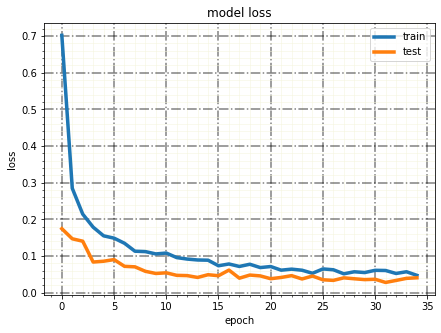

In [ ]:
plt.rcParams['figure.figsize'] = [7, 5]
x = np.linspace(0, 5, 50)
line1, = plt.plot(history.history['loss'],  linewidth=3.5)
line2, = plt.plot(history.history['val_loss'], linewidth=3.5)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

#major grid lines
plt.grid(b=True, which='major', color='black', alpha=0.5, linestyle='dashdot', lw=1.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)
plt.show()

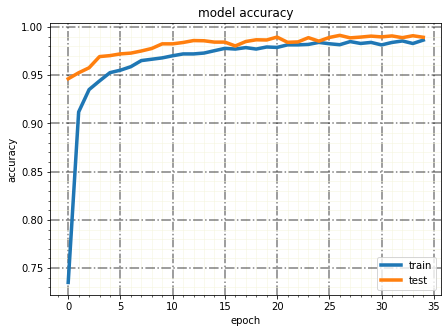

In [ ]:
plt.rcParams['figure.figsize'] = [7, 5]
x = np.linspace(0, 5, 50)
line1, = plt.plot(history.history['accuracy'],  linewidth=3.5)
line2, = plt.plot(history.history['val_accuracy'], linewidth=3.5)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

#major grid lines
plt.grid(b=True, which='major', color='black', alpha=0.5, linestyle='dashdot', lw=1.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)
plt.show()

# 8 layer CNN

In [ ]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation='relu', input_shape = (360,1)))
model.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation='relu')) 
model.add(Conv1D(filters=128, kernel_size=(5,), padding='same', activation='relu'))    

model.add(MaxPool1D(pool_size=(3,), strides=2, padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(units = 512, activation='relu'))
model.add(Dense(units = 1024, activation='relu'))
model.add(Dense(units = 5, activation='softmax'))

In [ ]:
adam=Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])
history1 = model.fit(train_x, train_y, batch_size=36, epochs=60, verbose=1, validation_data=(test_x, test_y))

Epoch 1/60
556/556 [==============================] - 5s 8ms/step - loss: 0.0762 - accuracy: 0.9836 - val_loss: 0.0643 - val_accuracy: 0.9854
Epoch 2/60
556/556 [==============================] - 4s 7ms/step - loss: 0.0921 - accuracy: 0.9785 - val_loss: 0.0475 - val_accuracy: 0.9894
Epoch 3/60
556/556 [==============================] - 4s 8ms/step - loss: 0.0721 - accuracy: 0.9826 - val_loss: 0.0705 - val_accuracy: 0.9820
Epoch 4/60
556/556 [==============================] - 4s 7ms/step - loss: 0.0628 - accuracy: 0.9834 - val_loss: 0.0651 - val_accuracy: 0.9818
Epoch 5/60
556/556 [==============================] - 4s 8ms/step - loss: 0.0735 - accuracy: 0.9815 - val_loss: 0.0689 - val_accuracy: 0.9818
Epoch 6/60
556/556 [==============================] - 4s 8ms/step - loss: 0.0756 - accuracy: 0.9817 - val_loss: 0.1282 - val_accuracy: 0.9692
Epoch 7/60
556/556 [==============================] - 4s 8ms/step - loss: 0.0738 - accuracy: 0.9826 - val_loss: 0.0553 - val_accuracy: 0.9880
Epoch 

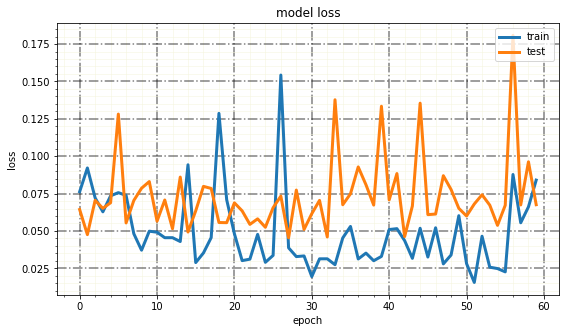

In [ ]:
plt.rcParams['figure.figsize'] = [9, 5]
x = np.linspace(0, 5, 50)
line1, = plt.plot(history1.history['loss'],  linewidth=3)
line2, = plt.plot(history1.history['val_loss'], linewidth=3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

#major grid lines
plt.grid(b=True, which='major', color='black', alpha=0.5, linestyle='dashdot', lw=1.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)
plt.show()

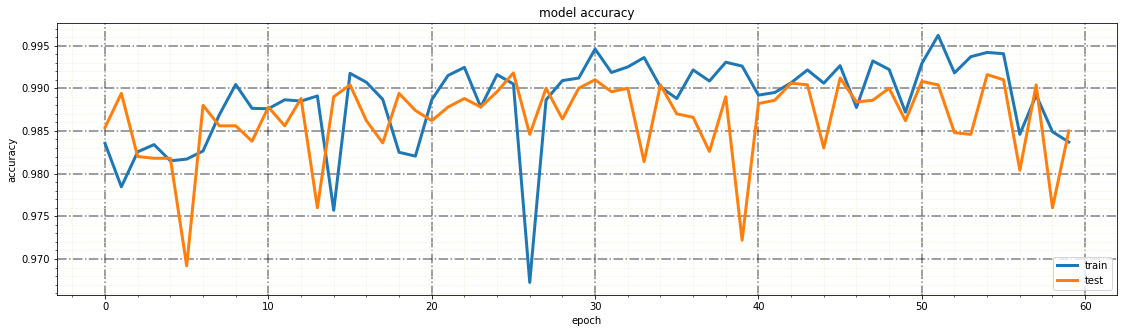

In [ ]:
plt.rcParams['figure.figsize'] = [19, 5]
x = np.linspace(0, 5, 50)
line1, = plt.plot(history1.history['accuracy'],  linewidth=3)
line2, = plt.plot(history1.history['val_accuracy'], linewidth=3)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

#major grid lines
plt.grid(b=True, which='major', color='black', alpha=0.5, linestyle='dashdot', lw=1.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)
plt.show()

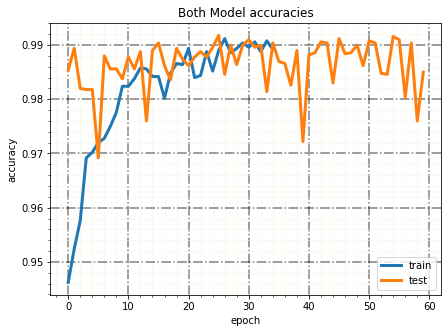

In [ ]:
plt.rcParams['figure.figsize'] = [7, 5]
x = np.linspace(0, 5, 50)
line1, = plt.plot(history.history['val_accuracy'],  linewidth=3)
line2, = plt.plot(history1.history['val_accuracy'], linewidth=3)
plt.title('Both Model accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

#major grid lines
plt.grid(b=True, which='major', color='black', alpha=0.5, linestyle='dashdot', lw=1.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)
plt.show()